# IRA Tweets: Analysis on Italian Tweets



In [323]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
from zipfile import ZipFile
import json
import folium

import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

### For the social good

The phenomenon of Russian IRA trolls has taken centre stage in the last months, casting a shadow on our understanding of the mechanisms which move social network discussions and debates in general.

In the last months we have started to be aware of the fact that Russian agencies have been using fake Twitter accounts to influence political results and manipulate people's opinions. In a period of political instability due to the economic crisis and the challenges that Western States are facing, it is all the more interesting to try to understand what are the means by which IRA acts to exacerbates the weaknesses of our society, by supporting populist parties and stressing the conflicts which characterise our countries.

Unless caution is not paid, we run the risk of some external entity imposing a certain mindset, orienting the political debate and pushing a particular point of view on delicate issues. Investigate the behaviour of Russian trolls means to foster informed and independent decisions, not spurred by heated online debates.

The focus of this analysis is on the Italian tweets of IRA, which have not yet been a specific object of study. We want to see if and how the action of trolls adapts to the specific Italian situation, and to do so we start by providing an overview of the Italian scenario.  

### Italian political context

Italy is nowadays seen as one of the weakest economies of the Eurozone, with high levels of unemployment and growth rates which fail to keep up with those of other countries. Its politics is particularly unstable and the electoral system fails to give rise to lasting governments and stable majorities, so that elections are frequent and the number of prime ministers in the last two decades is unrivalled, 14 in the last 24 years.

The political equilibrium has shifted towards less traditional parties following the economic crisis and the fall of Silvio Berlusconi, who has been the most stable political figure since 1994. The main parties at the moment are:

1. The **Democratic Party** (PD), a centre-left party which lacks a strrong leadership after Matteo Renzi lost popularity following a defeat in the 2006 constitutional referendum. Matteo Renzi has been secretary of the party from 2014 to 2016 and Prime Minister during the same years.

2. The **League**. Formerly known as the Northern League, a party supporting the independence of Northern Italy, the right-wing League set itself more national ambitions. It is a populist party, and currently the main party in the country, as well as the member of the coalition government together with M5S. Its key points are migration and the challenge of European rigidities in terms of budget limitations.

3. The **Five-Star Movement** (M5S) is a populist party, which aims at tackling social inequalities and fighting political privileges.

Both the League and the M5S hold eurosceptic positions, blaming the crisis on the common currency, the big financial institutions and the little flexibility available within the agreements of the European Union.

As many political commentators have stressed, a government formed by the M5S and the League is a threat to the stability of the Eurozone, and this is the reason why Russia, whose political ambitions are in conflict with those of the EU, might have all the interests to support it.

# 1. Data Reading and Exploration

### Reading the data

Data available:

1. a first version of the IRA tweets available [here](https://www.ka...-troll-tweets) ;

2. an updated collection of the IRA tweets which can be found [here](https://about.twitter.com/en_us/values/elections-integrity.html#data).

In the reading phase we read both the input data (corresponding to two zip files), we extract the italian tweets and we preprocess them. Finally, we store the result into two new csv files so as to be able to easily access the set of tweets we are interested in. 

We also store a csv file with the US tweets, for a future comparison of how differently trolls act in the case of the US and Italy. 

First we iterate through "russian-troll-tweets.zip" to read through every .csv file:

In [2]:
# Read the first IRA dataset
data_folder = './data/'
zip_file = ZipFile(data_folder+'russian-troll-tweets.zip')
fs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [3]:
fs['IRAhandle_tweets_1.csv'].head(2)

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


We append all datasets together in one DataFrame:

In [4]:
data=pd.DataFrame()
for key,val in fs.items():
    data=pd.concat([data,val])

In [5]:
data.describe()

,external_author_id,following,followers,updates,new_june_2018,retweet
count,2.973367e+06,2.973371e+06,2.973371e+06,2.973371e+06,2.973371e+06,2.973371e+06
mean,1.296128e+17,3.433524e+03,7.018913e+03,1.049756e+04,2.078735e-01,4.408955e-01
std,3.036341e+17,5.609881e+03,1.458463e+04,1.768729e+04,4.057859e-01,4.964945e-01
min,3.497640e+07,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,1.930748e+09,3.270000e+02,3.200000e+02,1.787000e+03,0.000000e+00,0.000000e+00
50%,2.581835e+09,1.499000e+03,1.274000e+03,4.333000e+03,0.000000e+00,0.000000e+00
75%,3.254274e+09,4.730000e+03,1.060000e+04,1.234100e+04,0.000000e+00,1.000000e+00
max,9.812510e+17,7.621000e+04,2.512760e+05,1.661130e+05,1.000000e+00,1.000000e+00


Here we preprocess the data, we notice that *content*, the main attribute of our analysis, has some null values. We prefer to remove them. Finally we also remove duplicate values of *content*. 

In [6]:
data.isnull().any()

external_author_id     True
author                False
content                True
region                 True
language              False
publish_date          False
harvested_date        False
following             False
followers             False
updates               False
post_type              True
account_type           True
new_june_2018         False
retweet               False
account_category      False
dtype: bool

In [7]:
data = data.dropna(subset= ['content'])
data.content.is_unique # Answer : False
data = data.drop_duplicates(subset = 'content')

We select only the italian tweets from the first 

In [8]:
# Italian tweets
italian_tweets = data[data.language == 'Italian']

# Italian tweets and not USA region
italian_tweets_notusa = italian_tweets[italian_tweets.region != 'United States']

In [9]:
italian_tweets.to_csv("italian_tweets_old.csv")
italian_tweets_notusa.to_csv("italian_tweets_old_notusa.csv")

We also import from a second dataset('ira_tweets_new.zip') and we repeat the previous analysis:

In [12]:
%%capture
# Read the second IRA dataset
zip_file = ZipFile(data_folder+'ira_tweets_new.zip')
interesting = ['rus_troll_tweet_text.csv',
               'rus_troll_tweet_stats.csv',
               'rus_troll_tweet_metadata.csv']
fs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename in interesting}

In [13]:
datanew=pd.DataFrame()
for key,val in fs.items():
    datanew=pd.concat([datanew,val], axis=1, sort=False)

In [14]:
datanew.isnull().any()

tweetid                 False
userid                  False
tweet_time              False
in_reply_to_tweetid      True
in_reply_to_userid       True
quoted_tweet_tweetid     True
is_retweet              False
retweet_userid           True
retweet_tweetid          True
quote_count             False
reply_count             False
like_count              False
retweet_count           False
hashtags                 True
urls                     True
user_mentions            True
poll_choices             True
tweetid                 False
tweet_language           True
tweet_text               True
tweetid                 False
follower_count          False
following_count         False
latitude                 True
longitude                True
tweet_client_name        True
dtype: bool

In [17]:
datanew = datanew.dropna(subset= ['tweet_text'])
datanew.tweet_text.is_unique # Answer : False
datanew = datanew.drop_duplicates(subset = 'tweet_text')

In [3]:
data4 = pd.read_csv(zip_file.open('rus_troll_user.csv'))
italian_tweets = datanew[datanew.tweet_language == 'it']
italian_tweets = pd.merge(italian_tweets, data4, on ='userid')
italian_tweets.shape
italian_tweets.to_csv("italian_tweets.csv")
italian_tweets.head(2)

### Authors: following and followers

> The idea in this part is to show the popolarity of the authors, according to the number of following/followers they have. We want to see if trolls use a specific strategy, for instance if they are extremely prolific or tend to keep low-key profiles.

We retrieve the two files created.

In [37]:
italian_tweets = pd.read_csv('italian_tweets.csv')
italian_tweets_old = pd.read_csv('italian_tweets_old.csv')
italian_tweets.columns

Index(['Unnamed: 0', 'tweetid', 'userid', 'tweet_time', 'in_reply_to_tweetid',
       'in_reply_to_userid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'quote_count', 'reply_count',
       'like_count', 'retweet_count', 'hashtags', 'urls', 'user_mentions',
       'poll_choices', 'tweetid.1', 'tweet_language', 'tweet_text',
       'tweetid.2', 'follower_count_x', 'following_count_x', 'latitude',
       'longitude', 'tweet_client_name', 'user_display_name',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'user_profile_url', 'account_creation_date',
       'account_language', 'follower_count_y', 'following_count_y',
       'last_tweet_at'],
      dtype='object')

In [38]:
italian_tweets.head(2)

,Unnamed: 0,tweetid,userid,tweet_time,in_reply_to_tweetid,in_reply_to_userid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,...,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,account_creation_date,account_language,follower_count_y,following_count_y,last_tweet_at
0,0,841607500931584000,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-14 11:10,NaN,NaN,NaN,True,95217122,8.416069e+17,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
1,1,842354395077533696,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-16 12:38,NaN,NaN,NaN,True,100185915,8.423537e+17,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35


In [39]:
italian_tweets_old.columns

Index(['Unnamed: 0', 'external_author_id', 'author', 'content', 'region',
       'language', 'publish_date', 'harvested_date', 'following', 'followers',
       'updates', 'post_type', 'account_type', 'new_june_2018', 'retweet',
       'account_category'],
      dtype='object')

In [40]:
#italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
#italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')

We modify the structure of the new dataset to match the previous one on the columns of interest.

In [41]:
italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')
italian_tweets=italian_tweets.rename(index=str, columns={"user_display_name":"author",
                                                         "follower_count_x": "followers",
                                                         "following_count_x": "following",
                                                         "tweet_time":"time"})
italian_tweets_old=italian_tweets_old.rename(index=str, columns={"publish_date":"time"})
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})

We calculate for each author the maximum number of following/followers by taking a group by on author and computing the maximum. We calculate the average in a similar way. Finally we plot the result in logarithmic scale.

In [42]:
# Concatenate the two dataset using columns of interest
followers=pd.concat([italian_tweets[['author','followers','time']],italian_tweets_old[['author','followers','time']]])

# Group by author and calculate max
followers=followers.groupby('author').agg({'followers': 'max'}).rename(columns={'followers':'max_followers'})

# Concatenate the two dataset using columns of interest
following=pd.concat([italian_tweets[['author','following','time']],italian_tweets_old[['author','following','time']]])

# Group by author and calculate max
following=following.groupby('author').agg({'following': 'max'}).rename(columns={'following':'max_following'})

In [43]:
# Concatenate the two dataset using columns of interest
avgfollowers=pd.concat([italian_tweets[['author','followers','time']],italian_tweets_old[['author','followers','time']]])

# Group by author and calculate mean
avgfollowers=avgfollowers.groupby('author').agg({'followers': 'mean'}).rename(columns={'followers':'mean_followers'})

# Concatenate the two dataset using columns of interest
avgfollowing=pd.concat([italian_tweets[['author','following','time']],italian_tweets_old[['author','following','time']]])

# Group by author and calculate mean
avgfollowing=avgfollowing.groupby('author').agg({'following': 'mean'}).rename(columns={'following':'mean_following'})

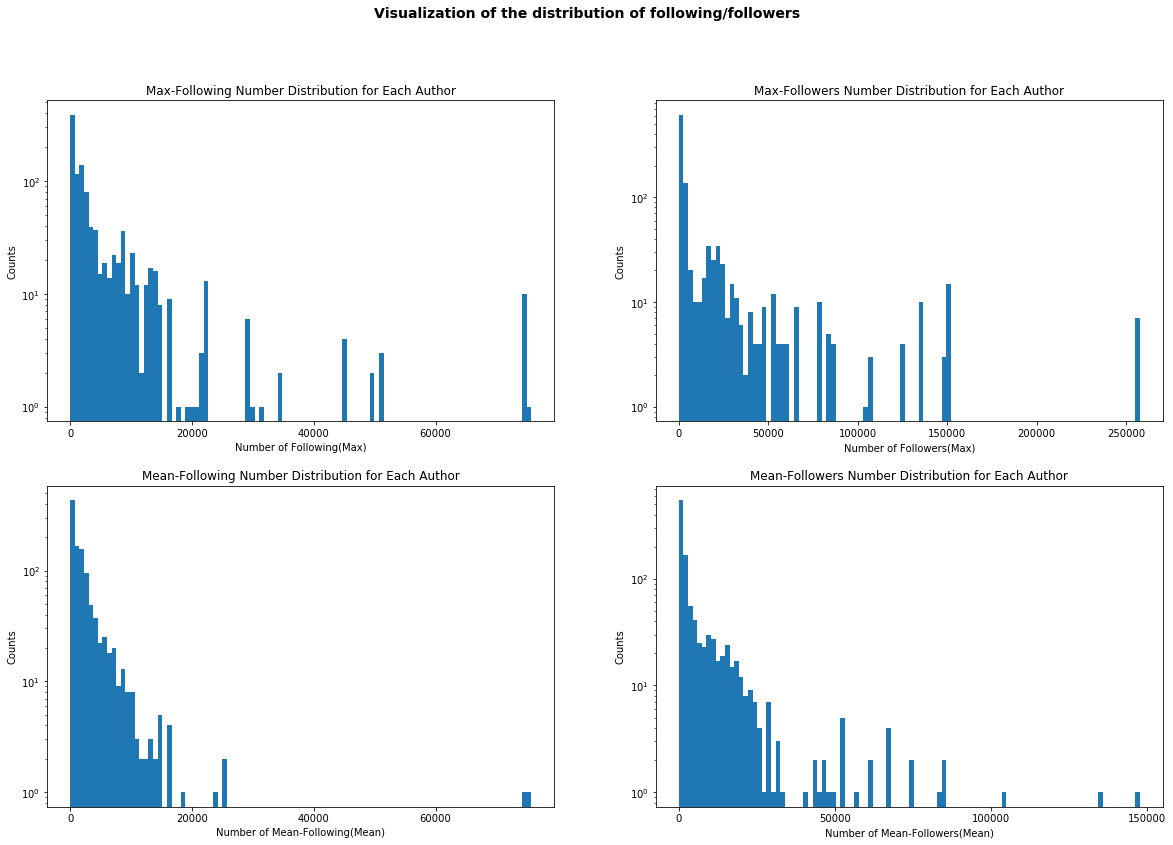

In [44]:
# Plot results
fig=plt.figure(figsize=(20,13))
fig.suptitle('Visualization of the distribution of following/followers', fontsize=14, fontweight='bold')

ax = fig.add_subplot(221)
ax.hist(following.max_following,bins=100,log=True)
ax.set_xlabel('Number of Following(Max)')
ax.set_ylabel('Counts')
ax.set_title(r'Max-Following Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

ax2 = fig.add_subplot(222)
ax2.hist(followers.max_followers,bins=100,log=True)
ax2.set_xlabel('Number of Followers(Max)')
ax2.set_ylabel('Counts')
ax2.set_title(r'Max-Followers Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

ax3 = fig.add_subplot(223)
ax3.hist(avgfollowing.mean_following,bins=100,log=True)
ax3.set_xlabel('Number of Mean-Following(Mean)')
ax3.set_ylabel('Counts')
ax3.set_title(r'Mean-Following Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

ax4 = fig.add_subplot(224)
ax4.hist(avgfollowers.mean_followers,bins=100,log=True)
ax4.set_xlabel('Number of Mean-Followers(Mean)')
ax4.set_ylabel('Counts')
ax4.set_title(r'Mean-Followers Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

plt.show()

We look further into this by zooming in on relatively smaller account: the followinf analysis aims at showing that the number of followers and following is quite balanced. However, we remark that the plots show that in general, trolls have more followers than they do have following.

In [45]:
counters=italian_tweets.groupby('author').count()
less_following = following.loc[following['max_following'] < 20000]
less_followers = followers.loc[followers['max_followers'] < 50000]

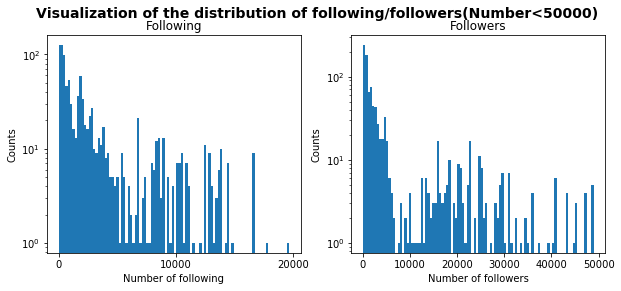

In [46]:
# Plot the results
fig=plt.figure(figsize=(10,4))
fig.suptitle('Visualization of the distribution of following/followers(Number<50000)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(121)

ax.hist(less_following.max_following,bins=100, log=True)
ax.set_xlabel('Number of following')
ax.set_ylabel('Counts')
ax.set_title(r'Following')
plt.locator_params(axis='x',nbins=4)

ax2 = fig.add_subplot(122)
ax2.hist(less_followers.max_followers,bins=100,log=True)
ax2.set_xlabel('Number of followers')
ax2.set_ylabel('Counts')
ax2.set_title(r'Followers')

plt.show()

> The large numbers we see -the number of author with a certain number of following/followers is relatively high- confirm us that the phenomenon of Russian trolls is quite widespread. As we could expect the number of followers tends to be higher than the number of people being followed by trolls. This suggest that there is an interest in their messages being heard.

### Authors: activity

In [47]:
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})

# Concatenate the two dataset using columns of interest
authors=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])

# Eliminate duplicates
dupli=authors.groupby(authors.content).size().reset_index().rename(columns={0:'nums'})
#dupli.nums
dupli=dupli[dupli.nums>1]
#authors=authors.drop_duplicates(subset='content')
#authors.head()

Here we count the total number of all contents:

In [48]:
authors.content.count()

35423

We find out that every content is unique:

In [49]:
len(authors.content.unique())

35051

In [50]:
authors.dtypes

content            object
author             object
time       datetime64[ns]
dtype: object

In [51]:
authors['time']=authors['time'].apply(lambda x: x.date())#Only keep the date
#Count total number of tweets the author sent out in one day:
authors=authors.groupby(['author','time']).agg('count').rename(columns={'content':'tot'})
#Take the average number of tweets one author sent out per day:
authors=authors.groupby(by='author',as_index=True).agg({'tot':'mean'}).reset_index().rename(columns={'tot':'avg'})

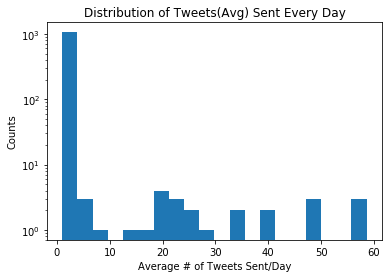

In [52]:
# Plot the results
plt.hist(authors.avg, log=True, bins=20)
plt.xlabel('Average # of Tweets Sent/Day')
plt.ylabel('Counts')
plt.title(r'Distribution of Tweets(Avg) Sent Every Day')
plt.show()

In [53]:
tweets=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
tweets.describe()

,content,author,time
count,35423,35423,35423
unique,35051,1085,18620
top,http://t.co/ayTWiV18K8 Amara @AmaraRoyce Jon @...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-29 15:17:00
freq,2,3482,12
first,NaN,NaN,2012-07-09 12:16:00
last,NaN,NaN,2018-03-31 01:07:00


In [54]:
prolific=authors.loc[authors.avg>20]
tweets_prolific=tweets.copy().merge(prolific,how='right',on='author')
tweets_prolific=tweets_prolific[tweets_prolific['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]
tweets_prolific.head(2)
num_prolific=tweets_prolific.size
num_tweets=tweets.size
print(str(round(num_prolific/num_tweets,2)))
tweets_prolific.head(1)
#tweets.describe()

0.72


,content,author,time,avg
0,RT @MuseoOmero: #14marzo #paesaggioitaliano Mo...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-14 11:10:00,57.081967


Conclusion

> Troll authors display different behaviours in terms of popularity and activity, which conveys the idea that they aim at targeting different people. While some of them are extremely prolific, some others have a more low-key profile. 

### Italian politicians

Here we focus on analyzing the frequency of several important italian politicians when they were mentioned in tweets. We try to find their appearance frequency in all tweets and in tweets with prolific authors separately. We want to see if prolific authors are more involved in political issues among the troll accounts, i.e. if the most active accounts are actively pushing the debate towards more political subjects.

As an aside, notice that the analysis was performed starting from 2017, since Salvini's popularity in the country started soar around that period. It would be less meaningful to include previous years in the queries.

In [55]:
#First we filter the tweets and only keep contents which are sent after 2017.01.01
tweets_2017=tweets[tweets['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]
prolific_2017=tweets_prolific[tweets_prolific['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]

In [56]:
renzi=prolific_2017[prolific_2017['content'].apply(lambda x: 'renzi' in x.lower())]
mentions1=renzi.content.count()
print("'Renzi' mentioned in tweets_prolific:", mentions1, "times")

'Renzi' mentioned in tweets_prolific: 444 times


In [57]:
renzi=tweets_2017[tweets_2017['content'].apply(lambda x: 'renzi' in x.lower())]
mentions2=renzi.content.count()
print("'Renzi' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'Renzi' mentioned in all tweets: 587 times
Mentions by prolific authors: 0.76


Matteo Renzi is an Italian politician who served as the Prime Minister of Italy from February 2014 until December 2016(from wikipedia). From above data, he was mentioned 481 times in tweets with prolific authors, and 643 times in all tweets.

In [58]:
salvini=prolific_2017[prolific_2017['content'].apply(lambda x: 'salvini' in x.lower())]
mentions1=salvini.content.count()
print("'Salvini' mentioned in tweets_prolific:", mentions1, "times")

'Salvini' mentioned in tweets_prolific: 135 times


In [59]:
salvini=tweets_2017[tweets_2017['content'].apply(lambda x: 'salvini' in x.lower())]
mentions2=salvini.content.count()
print("'Salvini' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'Salvini' mentioned in all tweets: 185 times
Mentions by prolific authors: 0.73


Matteo Salvini has also been Federal Secretary of Northern League since December 2013 and the leader of Us with Salvini since December 2014(from wikipedia). From above data, he was mentioned 145 times in tweets with prolific authors, and 196 times in all tweets.

In [60]:
grillo=prolific_2017[prolific_2017['content'].apply(lambda x: 'grillo' in x.lower())]
mentions1=grillo.content.count()
print("'Grillo' mentioned in tweets_prolific:", mentions1, "times")

'Grillo' mentioned in tweets_prolific: 129 times


In [61]:
grillo=tweets_2017[tweets_2017['content'].apply(lambda x: 'grillo' in x.lower())]
mentions2=grillo.content.count()
print("'Grillo' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'Grillo' mentioned in all tweets: 157 times
Mentions by prolific authors: 0.82


Beppe Grillo has been involved in politics since 2009 as the co-founder (together with Gianroberto Casaleggio) of the Italian Five Star Movement political party(from wikipedia). From above data, he was mentioned 139 times in tweets with prolific authors, and 172 times in all tweets.

In [62]:
lega=prolific_2017[prolific_2017['content'].apply(lambda x: 'lega' in x.lower())]
mentions1=lega.content.count()
print("'Lega' mentioned in tweets_prolific:", mentions1, "times")
lega=tweets_2017[tweets_2017['content'].apply(lambda x: 'lega' in x.lower())]
mentions2=lega.content.count()
print("'Lega' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'Lega' mentioned in tweets_prolific: 233 times
'Lega' mentioned in all tweets: 334 times
Mentions by prolific authors: 0.7


In [63]:
pdem=prolific_2017[prolific_2017['content'].apply(lambda x: 'pd' in x.lower())]
mentions1=pdem.content.count()
print("'PD' mentioned in tweets_prolific:", mentions1, "times")
pdem=tweets_2017[tweets_2017['content'].apply(lambda x: 'pd' in x.lower())]
mentions2=pdem.content.count()
print("'PD' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'PD' mentioned in tweets_prolific: 772 times
'PD' mentioned in all tweets: 1072 times
Mentions by prolific authors: 0.72


**Conclusions**

> We see that Renzi, the leader of the centre left party has a greater number of mentions than the other political leaders. Renzi's hedge, hoever, is not so large considering that he was also the main member of the leading party in the coalition government during the period when tweets were produced. Matteo Salvini, instead, was just a member of the European Parliament during the same years.

> Bepper Grillo, founder of the Five-Star Movement, also features strongly in the tweets, despite not even being a politician by profession.

> In general we see that the coverage of leaders who were not in the coalition government (Grillo, Salvini) is pretty impressive and show interest on less traditional political forces: we hope sentiment analysis can shed further light on the tone of tweets related to populist vs. more traditional parties.

> Notice that the mention of political leaders occur mostly by prolific authors: while prolifc authors produced 72% of the tweets, they accounted for more than 82% of tweets on Beppe Grillo.

> Lastly, we see that the ratio of tweets mentioning Salvini to those mentioning the *League* is higher than that of tweets mentioning Renzi to those mentioning *PD*: this might be related to the willingness of trolls to highlight the idea of a strong leader, Salvini, personalising the *League* party.  

### Geographical analysis 

Here we calculate the distribution of references to Italian communes (Italian: *comune*) and regions (Italian: *regione*).

We know that different regions of the country have historically different political behaviours. Specifically:

1. the League has traditionally been the strongest party in the **North-East** of the country, fighting for independence from Southern Italy. After changing name from *North League* to *League*, it started obtaining consensus in the rest of the country, focusing on themes such as Europe, immigration and terrorism;

2. the **southern part** of the Country features worse economic conditions, with lower wages and higher unemployment. It is the area where M5S could grow the most, especially by promising basic income once in power: 2018 elections showed huge popularity of this party in southern Italy.

We are interested in finding if trolls exploited these regional differences. We thus look if there is a connection between the number of mentions to regions and municipalities of Italy to see if they match political outcomes: the idea is that trolls might have especially tried to mention regions where social problems were more serious, which are the same regions where traditional parties turned out to be weaker in the elections.

We look for:

1. a list of Italian **municipalities**,

2. a list of Italian **regions**,

and count all mentions of municipalities and regions. Finally, we group by region to have a more general picture.


The data come from the *Italian Institute of Statistics*, ISTAT, and are available [here](https://www.istat.it/it/archivio/6789).

In [66]:
#We find an excel form called "comuni.xls", and read it:
munic = pd.read_excel('comuni.xls')
munic=munic.rename(columns={'Denominazione in italiano':'comune','Denominazione regione':'regione'})[['comune','regione']]
munic.regione=munic.regione.apply(lambda x: x.lower())
munic['count']=0

#We set commune as the index here. And one region contains several communes:  
munic=munic.set_index('comune')
munic.head(2)

,regione,count
comune,,
Agliè,piemonte,0
Airasca,piemonte,0


We group all communes according to their regions, and calculate the total number of regions in each comune:

In [67]:
def wordInString(word, string_value):
    return True if re.search(r'\b' + word + r'\b', string_value) else False

In [68]:
def count_c(name):
    tweet_comune=tweets[tweets['content'].apply(lambda x: wordInString(name, x))]
    total=tweet_comune.content.count()
    munic.at[name, 'count']=total

In [69]:
def count_r(name):
    tweet_reg=tweets[tweets['content'].apply(lambda x: wordInString(name.lower(), x.lower()))]
    total=tweet_reg.content.count()
    reg.at[name, 'tot']=reg.loc[name,'tot']+total

In [70]:
list_comuni=munic.index.tolist()
for m in list_comuni:
    count_c(m)

In [71]:
reg=munic.groupby(by='regione')['count'].agg('sum').reset_index().rename(columns={'count':'tot'}).set_index('regione')

In [72]:
list_regioni=reg.index.tolist()
for m in list_regioni:
    count_r(m)

The result is the following:

In [157]:
reg

,tot
regione,
abruzzo,97
basilicata,116
calabria,311
campania,753
emilia-romagna,362
friuli-venezia giulia,56
lazio,1072
liguria,184
lombardia,822


In [158]:
list_regioni.append('valle d\'aosta / vallée d\'aoste')
list_regioni.append('trentino alto adige / südtirol')

popul = pd.read_csv('pop.csv')
popul=popul.loc[(popul.Sesso=='totale') &
                (popul['Stato civile']=='totale') &
                (popul.TIPO_DATO15=='JAN') &
                (popul.Età=='totale')]
popul.Territorio=popul.Territorio[popul.Territorio.
                                  apply(lambda x: x.lower() in list_regioni)].apply(lambda x: x.lower())
popul.Territorio=popul.Territorio.replace(['valle d\'aosta / vallée d\'aoste','trentino alto adige / südtirol'],
                    ['valle d\'aosta/vallée d\'aoste','trentino-alto adige/südtirol'])
popul=popul.dropna(subset=['Territorio'])[['Territorio','Value']].set_index('Territorio').drop_duplicates()
popul

,Value
Territorio,
piemonte,4375865
valle d'aosta/vallée d'aoste,126202
liguria,1556981
lombardia,10036258
trentino-alto adige/südtirol,1067648
veneto,4905037
friuli-venezia giulia,1215538
emilia-romagna,4452629
toscana,3736968


In [159]:
relative_reg=reg.merge(popul,left_on=reg.index, right_on=popul.index).set_index('key_0')
relative_reg.index.names = ['Region']
relative=relative_reg.tot/relative_reg.Value*1e5
relative_reg['relative']=relative
relative_reg=relative_reg.sort_values(by='relative',ascending=False)
relative_reg

,tot,Value,relative
Region,,,
trentino-alto adige/südtirol,288,1067648,26.975183
molise,66,308493,21.394327
basilicata,116,567118,20.454297
lazio,1072,5896693,18.179681
calabria,311,1956687,15.894213
campania,753,5826860,12.922912
liguria,184,1556981,11.817742
piemonte,453,4375865,10.352239
veneto,472,4905037,9.622761


The electoral results from the 2018 elections can be found for example [here](https://www.youtrend.it/mappa-elezioni-2018/).

In [160]:
diz={'abruzzo':'M5S', 
      'basilicata':'M5S', 
      'calabria':'M5S', 
      'campania':'M5S', 
      'emilia-romagna':'cdx', 
      'friuli-venezia giulia':'cdx', 
      'lazio':'cdx', 
      'liguria':'cdx', 
      'lombardia':'cdx', 
      'marche':'M5S', 
      'molise':'M5S', 
      'piemonte':'cdx', 
      'puglia':'M5S', 
      'sardegna':'M5S', 
      'sicilia':'M5S', 
      'toscana':'csx', 
      'trentino-alto adige/südtirol':'cdx', 
      'umbria':'cdx', 
      'valle d\'aosta/vallée d\'aoste':'other', 
      'veneto':'cdx'}
results=pd.DataFrame.from_dict(diz,orient='index')
results
relative_reg['results']=results
relative_reg=relative_reg.rename(index={'valle d\'aosta/vallée d\'aoste':'valle d\'aosta',
                                        'trentino-alto adige/südtirol':'trentino-alto adige'})
relative_reg

,tot,Value,relative,results
Region,,,,
trentino-alto adige,288,1067648,26.975183,cdx
molise,66,308493,21.394327,M5S
basilicata,116,567118,20.454297,M5S
lazio,1072,5896693,18.179681,cdx
calabria,311,1956687,15.894213,M5S
campania,753,5826860,12.922912,M5S
liguria,184,1556981,11.817742,cdx
piemonte,453,4375865,10.352239,cdx
veneto,472,4905037,9.622761,cdx


In [180]:
ita_path = './italy/italy_reg.json'
geo_json_data = json.load(open(ita_path))
m_it = folium.Map([41.8,12.33], tiles='cartodbpositron', zoom_start=5.5, width='60%')

geoms=[geom for geom in geo_json_data['objects']['sub']['geometries']]
regs=[geo['properties']['name'] for geo in geoms]
colours=['#0000ff','#ff0000','#FFFF00','#00ff00']
coalitions=['cdx','csx','M5S','other']
it_colours=dict(zip(coalitions, colours))

def region_colour(region):
    """
    Maps a given region to a colour.
    """
    reg=region.lower()
    win=relative_reg.at[reg,'results']
    return it_colours[win]

folium.TopoJson(geo_json_data,'objects.sub',
               style_function=lambda x: {
                    'fillColor': region_colour(x['properties']['name']),
                    'color' : 'black',
                    'weight' : 2,
                }).add_to(m_it)
m_it

In [176]:
relative_reg['name']=relative_reg.index
relative_reg.name=relative_reg.name.apply(lambda x: x.upper())

In [182]:
m_ment = folium.Map([41.8,12.33], tiles='cartodbpositron', zoom_start=5.5, width='60%')
m_ment.choropleth(geo_data=geo_json_data, data=relative_reg,
             columns=['name', 'relative'],
             key_on='feature.properties.name',
             topojson='objects.sub',
             fill_color='OrRd', fill_opacity=1.5, line_opacity=9,
             legend_name='Relative number of tweet mentions')
m_ment

**Conclusion**

> The 2018 General Elections in Italy saw an unprecedented success of populist parties. In particular Southern Italy (Campania, Sicilia, Puglia, Lazio) was key in the success of the Five-Star Movement, while North-West regions (like Veneto) were more than ever loyal to the right-wing League party. 

> The analysis by region indeed shows that these regions were highly targeted by trolls: in a normalised count of mentions of regions and communes, the regions which turn out to be most mentioned are the Southern ones, which mainly contributed to the success of M5S. 

> As for Northern Italy, if we exclude small Liguria, the most targeted region was Veneto, which is traditionally associated with *League*.

### Time analysis

Is there a peak of activity of trolls during significant moments of the past years? If trolls intend to influence our perception of politics and society, we would expect them to give relevance to disruptive events, crisis and elections and to be more active on these occasions.

To get a visual intuition of this fact we plot the historical evolution of the number of tweets per day.

In [56]:
times=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
#times.loc[times['time'].apply(lambda x:x==datetime.strptime('26-03-2017', '%d-%m-%Y'))]
times=times.drop_duplicates(subset='content')

In [57]:
start_date_tweet = times['time'].min()
end_date_tweet = times['time'].max()
print(start_date_tweet, end_date_tweet)

2012-07-09 12:16:00 2018-03-31 01:07:00


In [58]:
times.dtypes

content    object        
author     object        
time       datetime64[ns]
dtype: object

In [59]:
#times=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
times['time']=times['time'].apply(lambda x: x.date())#authors.head()
times['time'] = pd.to_datetime(times['time'])

In [60]:
times=times.groupby(by='time',as_index=True).agg({'content':'count'}).reset_index().rename(columns={'content':'tot'})
times.sort_values(by='time', ascending = True, inplace = True)
times=times.set_index('time')

In [61]:
times.dtypes

tot    int64
dtype: object

In [62]:
times.head()

,tot
time,
2012-07-09,11
2012-07-10,20
2012-07-11,1
2012-07-12,11
2012-07-27,1


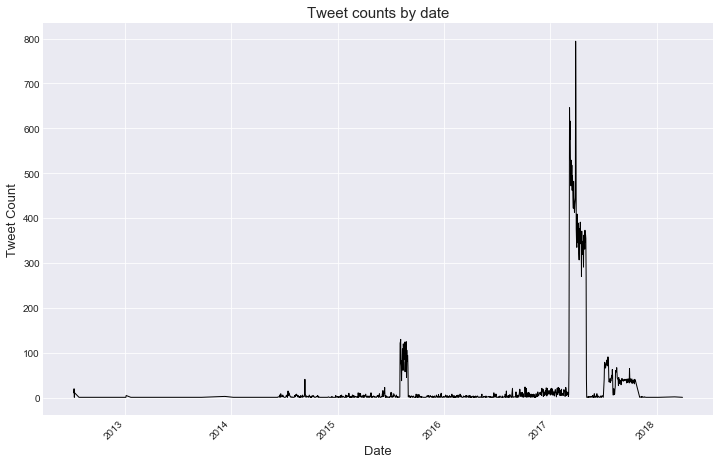

In [63]:
plt.style.use('seaborn-darkgrid')
times['tot'].plot(linestyle = "-", figsize = (12,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

plt.show()

We observe a period of exceptional activity in the first months of 2017. These corresponded to months of political tension across Europe due to the presence of numerous terrorists' attacks: London, Stockholm, Paris, St Petersburg, Manchester were among the cities which witnessed these attacks. The idea is that one of the challenges Europe is facing is how to deal with immigration and its consequences. Populist parties tend to answer to this issue in a simplistic way, refusing immigration in all its forms. Of course Russian trolls would use the rise of Islamic terrorism as a sign of the difficulties of Europe and as a way to support the messages of populist parties.

Wenow zoom in on the other months and look for further evidence of the divisive strategy of trolls.

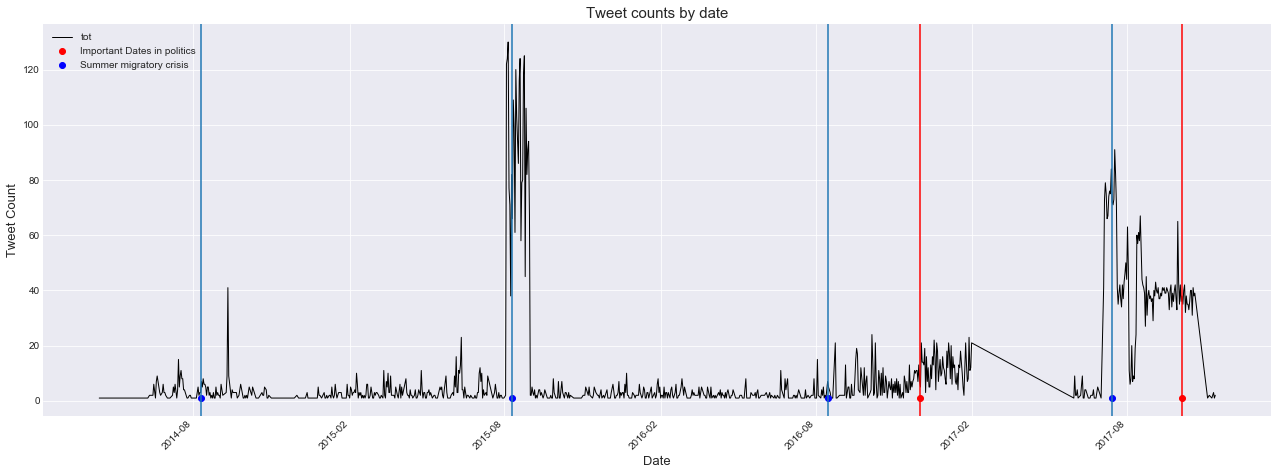

In [64]:
peak=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
peak=peak.drop_duplicates(subset='content')
peak=peak[peak['time'].apply(lambda x:
                         ((x<datetime.strptime('01-02-2017', '%d-%m-%Y') or 
                          (x>datetime.strptime('31-05-2017', '%d-%m-%Y'))) & 
                          (x>datetime.strptime('01-03-2014', '%d-%m-%Y')) & 
                          (x<datetime.strptime('15-11-2017', '%d-%m-%Y')))
                        )]
peak['time']=peak['time'].apply(lambda x: x.date())#authors.head()
peak['time'] = pd.to_datetime(peak['time'])
peak=peak.groupby(by='time',as_index=True).agg({'content':'count'}).reset_index().rename(columns={'content':'tot'})
peak.sort_values(by='time', ascending = True, inplace = True)
peak=peak.set_index('time')

dates_list = ['2016-12-01','2017-10-05']
# 08-2017
# March-May 2017 terror attacks in Europe: London, Stockholm, Paris, St Petersburg, Manchester
# 12-2016 Italian referendum
# 08-2015 Migratory crisis in Europe
# 05-2014 European elections
important_dates = pd.Series(pd.to_datetime(dates_list))

summer = ['2017-07-15','2016-08-15','2015-08-10','2014-08-10']
summer_dates = pd.Series(pd.to_datetime(summer))

# add columns to identify important events, and mark a 0 or 1.
peak['Summer Events'] = False
peak.loc[summer_dates, 'Summer Events'] = True
peak['vals'] = 0
peak.loc[summer_dates, 'vals'] = 1

peak['Important Events'] = False
peak.loc[important_dates, 'Important Events'] = True
peak['values'] = 0
peak.loc[important_dates, 'values'] = 1

plt.style.use('seaborn-darkgrid')
peak['tot'].plot(linestyle = "-", figsize = (22,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

plt.plot(peak[peak['Important Events'] == True].index.values,
         peak.loc[peak['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none',
        label = 'Important Dates in politics')

plt.plot(peak[peak['Summer Events'] == True].index.values,
         peak.loc[peak['Summer Events'] == True, 'vals'],
         marker = 'o', 
         color = 'b',
         linestyle = 'none',
        label = 'Summer migratory crisis')

for m in peak[peak['Summer Events'] == True].index.values:
    plt.axvline(x=m)
    
for m in peak[peak['Important Events'] == True].index.values:
    plt.axvline(x=m, color='r')

plt.legend(loc = 'best')

plt.show()

We highlighted:

1. migratory crisis;

2. the Italian constitutional referendum, whose outcome was one of the main causes of the fall of the centre-left party;

3. the build-up to the general elections.

**Conclusion**

> Three patterns emerge from the time analysis:

> 1. intense activity during the summer months: these are the times when Italy is heavily affected by migratory crisis. Further analysis shows that migration is one of the top themes picked by trolls, and one which contributes to the rise of left-wing political party *League*;

> 2. high activity during significant political events: the constitutional referendum in 2016 and the weeks leading up to the General Elections at the beginning of 2018. This is coherent with IRA's intention to influence political results;

> 3. high activity in the months March-May 2017: troll might have wanted to stress the climate of instability in Europe and spur rage against Islam, giving rise to populist attitudes in European countries.


> If, as we claim, Russian trolls aim at spurring political instability in Europe, it is natural that they should focus on disruptive events showing the weaknesses of our society. Also, they would be likely to touch upon themes that are key in the political agenda of populist parties (*Leaugue* and *Five-Star Movement*), making Europe more frail and threatening the stability of international relationships. They would naturally encourage political debate, creating divisiveness in the country.

> What we see is indeed that they are more active during periods coinciding with peaks of terrorism in Europe, migratory crisis and political events.

# 2. Data Mining

In this section we exploit some data mining technique to explore recurring themes, frequent words, and words often appearing together.

Some key points emerged in the previous discussion about trolls. Will they find a correspondence in the following analysis?

For the sake of clarity, we review the main ideas collected until now and present expected related results.

1. Trolls showed mixed strategies in terms of account size (followers and following) and activity (number of tweets produced): on the same line, we expect to see that a broad variety of topics is touched by trolls, to engage as vast a public as possible; <br/>

2. peaks of activity during particular periods, especially when it comes to delicate occurrences (terror attacks), major political events or crisis: we expect that in the wide range of themes emerging from the discussions, a prominent role is played by political facts and social problems;

3. particularly relative high mentions to some regions, which brodaly coincide with those whose political centre of mass was shifting towards populist parties: we expect that themes frequently addressed by these parties are also touched by trolls.

The starting point is as usual the retrieval of our tweets.

In [269]:
italian_tweets = pd.read_csv('italian_tweets.csv')
italian_tweets_old = pd.read_csv('italian_tweets_old_notusa.csv')
#italian_tweets['user_reported_location']

In [270]:
italian_tweets=italian_tweets.loc[italian_tweets['user_reported_location'] != 'Estados Unidos']
italian_tweets.shape

(18621, 37)

In [271]:
italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')
italian_tweets=italian_tweets.rename(index=str, columns={"user_display_name":"author",
                                                         "follower_count_x": "followers",
                                                         "following_count_x": "following",
                                                         "tweet_time":"time"})
italian_tweets_old=italian_tweets_old.rename(index=str, columns={"publish_date":"time"})
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})
ita=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
#ita=ita.drop_duplicates(subset='content')
regex = re.compile('[^a-zA-Z ]')
def returntest(text):
    text=text.lower()
    text=regex.sub('',text) 
    text=re.sub(r'(\s)http\w+', r' ', text)
    return text
new_text = ita.content.apply(returntest)
print(new_text.head(3))
new_text.to_csv("tweets_ita.csv")

italian_tweets.shape

0    rt museoomero marzo paesaggioitaliano mole van...
1    rt radiotweet la ministra valeriafedeli incont...
2    rt radiorai news attacco londra may riunisce c...
Name: content, dtype: object


(18621, 37)

In [273]:
italian_tweets_text = pd.read_csv('tweets_ita.csv',header=None)
print(italian_tweets_text.shape)
stopwords = pd.read_json('stopwords-it.json')

(31690, 2)


In [274]:
stopwords = stopwords[0].tolist()

Note that we decide to ignore smaller words, but we still keep *pd* and *ms*, which stand for *Democratic Party* and *Five-Star Movement*.

In [340]:
list_final = []
for text in italian_tweets_text[1]:
    list_final.append([word.lower() for word in text.split() 
                       if (word.lower() not in stopwords and
                           (len(word)>3 or word in ['pd','ms']))])

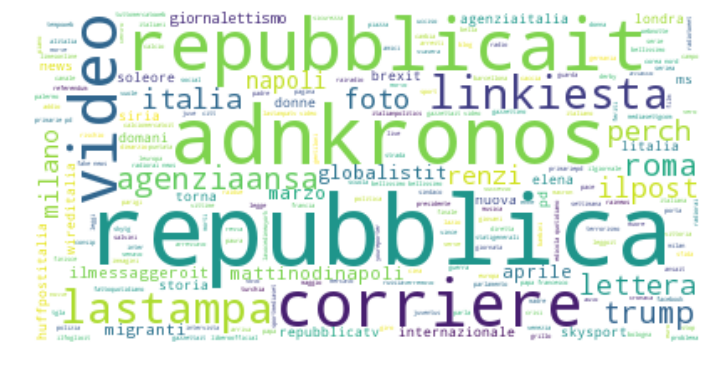

In [341]:
text = " ".join([word for tweet in list_final for word in tweet])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud highlights a macroscopic feature of the trolls' strategy, namely the willingness to refer to well-known and recognised newspapers and agencies when spreading news events. The most cited ones are 

    * la Repubblica,
    * Corriere della Sera,
    * La Stampa,
    * ANSA,
    * AD Kronos.
    
The fact that these sources are generally considered to be reliable by a large share of the population, and are definitely the most popular, would confirm the thesis by which trolls would try to engage a wide range of followers and to present themselves as reliable, and, in general, by no means extremist.

We now filter out the names of the main Italian papers and agencies, to see whether further intuitions emerge from the tweets' collection: the list of papers cannot be exhaustive, but combines the one offered by [Wikipedia](https://it.wikipedia.org/wiki/Quotidiani_in_Italia) with our personal knowledge.

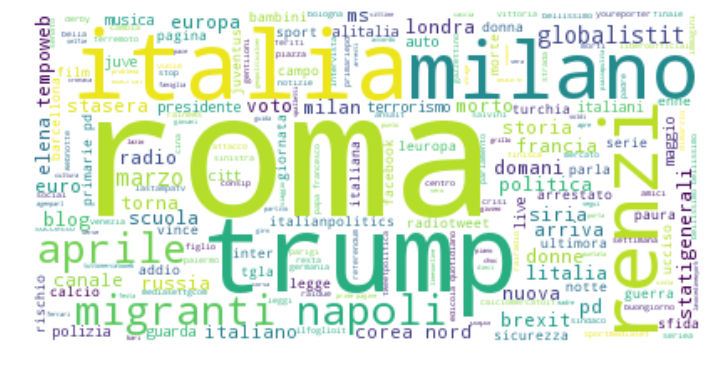

In [342]:
papers=['Corriere della Sera','repubblica','repubblicait','SoleORE','QuotidianoNazionale',
        'Gazzettait','laStampa','ilMessaggeroit','quotidianonazionale','ilpost',
        'corriere','ilgiornale','Avvenire','Tuttosport','libero','leggoit',
        'FattoQuotidiano','Mattinodinapoli','huffpost','linkiesta',
        'adnkronos','agenziaansa','video','giornalettismo','ilpost',
        'lettera','huffpostitalia','agenziaitalia','skytg','skysport','internazionale',
        'perch','foto','repubblicatv','wireditalia','news','diretta','leggo','radiorai']
papers=[m.lower() for m in papers]
for el in list_final:
     if el in papers:
            list_final.remove(el)
text = " ".join([word for tweet in list_final for word in tweet if word not in papers])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Following what was being discussed in previous points, we start by stressing that trolls strive not to be monothematic. Although, as expected, the main words relate to politics, a more careful observation shows the presence of:

    * music,
    * football (Juve, Milan, Inter),
    * weather forecasts,
    * history,
    * Formula 1 (Ferrari).
    
More interesting to trolls, however are socio-political issues: we try to provide possible explanations of why some words might be appearing, in the light of previous hypothesis and of the current global context.

* **National Politics**
    * Grillo, Renzi, Salvini, Gentiloni (Italian Prime Minister, 2016-2018).
    * *primarie*: vote to nominate the leader of a party.
    * consip
    * referendum, elections
    * left (but not right...)
    * migrants, police, security
    * earthquake
    
    National politics seem to be dominated by the problems internal to the centre-left party (PD): few words seem to refer to the operations of the government, while the majority of mentions seem to be related to the crisis of the Democratic Party (the *referendum* which lead to the fall of the Party, the *primarie* to find the leader of *PD*, the scandal of CONSIP, which concerned people close to Matteo Renzi,...). 

    At the same time there is a wide reference to topics, such as security and migrants, which have dominated the electoral campaign in 2018 and are still the main reason why the *League* popularity seems unstoppable.
    
    
* **International Politics**
    * Brexit, Euro and Europe,
    * casualties, deaths, injured, die, dead,
    * fear, terror, risk, terrorism, massacre, attack,
    * France, Germany,
    * war,
    * Russia, Syria, Turkey,
    * Trump.
    
    As mentioned in previous sections, topics in international politics mainly concern weaknesses of the European Union: terror attacks, Brexit, the common currency... The lexicon seem to be dominated by negative words, which conveys the idea of the current situation in Europe as doomed. But there is more to it. Except for Germany and France, the countries mentioned have one common feature: they are ruled by authoritarian leaders: Erdogan, Assad, Putin. Of course, a similar idea holds for Trump, which is typically perceived as strong and tough, especially in terms of migration. 
    
    Also, notice that Syria is the one of the main interests of the Russian foreign politics.
    
Looking at the biggure picture, it comes as no surprise that strong leaders come alongside with the image of a weak left party (PD) and of a weak institution (EU), characterised by defections (Brexit) and terror attacks. In addition, populist parties in Italy are known to refer to the Russian model (Putin) and, although with some exceptions the American one (Trump): credits to [la Repubblica](https://www.repubblica.it/esteri/2016/04/26/news/usa_salvini_incontra_donald_trump_a_philadelphia-138469767/) for the picture of the *League* leader, Matteo Salvini, with Donald Trump.
<img src="salvini_trump.jpg" alt="Drawing" style="width: 400px;"/>

In [348]:
wordcloud.words_

## Association Rules

We know try to get a closer look by applying data mining techniques to the collection of tweets. We start by association rules, to see which words often come together.

In [276]:
te = TransactionEncoder()
te_ary = te.fit(list_final).transform(list_final)
df = pd.DataFrame(te_ary,columns=te.columns_)

In [277]:
frequent_items = apriori(df, min_support=0.001, use_colnames=True, max_len = 2)

In [318]:
couple = frequent_items [frequent_items['itemsets'].apply(lambda x: len(x)==2)]
couple = couple.sort_values(by=['support'],ascending= False)
couple.head(2)

,support,itemsets
1096,0.005396,"(pd, renzi)"
1057,0.004954,"(corea, nord)"


In [319]:
table = association_rules(frequent_items, metric="confidence", min_threshold=0.2)
table = table.sort_values(by=['confidence'],ascending= False)

In [321]:
pd.set_option("display.max_rows",999)
table.head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21,(carmenpiscopo),(elena),0.001388,0.00751,0.001294,0.931818,124.072765,0.001283,14.556516


To provide a more orderly visualisation, we classify the most interesting association rules based on the topic.

### National Politics

Together with the patterns described in the previous section, we now see that Beppe **Grillo**, the founder of the Five-Star Movement, is frequently associated to the world *blog*, which, in all likelihood, is a reference to the [blog](https://www.ilblogdellestelle.it) of the M5S Party. In other words, unlike other parties, it looks like when mentioning Beppe Grillo, Russian trolls also refer to the official web magazine of the Party.

Again, the Democratic Party **PD** and Matteo **Renzi** are mostly associated to the signs of the decline of the same party: the CONSIP scandal and the internal rivalries: Orlando and Emiliano were the other candidates to the secretary of the Party.

In addition, Matteo **Salvini** is associated to Napoli, the biggest city of Southern Italy: this is peculiar, Salvini being a politician that used to promise the independence of Northern Italy...

Laslty, it is significant that **law** is a significant consequent of electoral: indeed, the weakness of the Italian political system is attributed to the lack of a solid electoral law.

In [325]:
list_ids = [74,81,38,26,36,53,10,66]
important_tweets = pd.Series(list_ids)
table['vals'] = 0
table.loc[important_tweets, 'vals'] = 1
table.loc[table.vals==1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Note,vals
74,(primarie),(pd),0.004828,0.015715,0.004292,0.888889,56.564034,0.004216,8.858567,True,1
36,(elettorale),(legge),0.001641,0.006721,0.001104,0.673077,100.139942,0.001093,3.038264,True,1
66,(salvini),(napoli),0.004418,0.011108,0.001862,0.421429,37.940544,0.001813,1.709197,True,1
81,(primariepd),(renzi),0.002745,0.015052,0.001010,0.367816,24.436251,0.000968,1.558009,True,1
38,(orlando),(emiliano),0.003440,0.003881,0.001262,0.366972,94.547624,0.001249,1.573579,True,1
26,(consip),(renzi),0.003503,0.015052,0.001041,0.297297,19.751261,0.000989,1.401657,True,1
53,(grillo),(ms),0.004165,0.008173,0.001136,0.272727,33.369603,0.001102,1.363762,True,1
10,(grillo),(blog),0.004165,0.008110,0.001104,0.265152,32.695142,0.001071,1.349789,True,1


### International Politics

While in the Word Cloud representation we had focused on the European situation, association rules shed light on the global context, and particularly to the North Korean and Syrian issues. The words **missiles** are associated to both **Syria** and **Korea**, which is in turn associated to *North*.

**Putin** is featured as the antecedent of **Trump**: although the relation between the two countries experiences ups and downs, the two men share similar personal characteristics. 

Lastly, we want to stress the pair **Le Pen**, **Macron**: Le Pen is often see as the analogue of Matteo Salvini in France, while parallels have been drawn between Renzi and Macron (in spite of some undeniable differences). Marine Le Pen is certainly making the most of the European populist wave, exactly like Matteo Salvini and together they have contributed to the erosion of traditional politcal parties.

Credits to [La Stampa](https://www.lastampa.it/2018/10/09/esteri/salvinile-pen-e-il-fronte-delle-libert-saremo-le-bestie-nere-dei-partiti-storici-Yo1e3jL7pakouIQz4JxM6H/pagina.html) for the picture of the *League* leader, Matteo Salvini, with Marine Le Pen. <img src="salvini_lepen.jpg" alt="Drawing" style="width: 400px;"/>

In [326]:
inter_ids = [58,27,30,67,64,65,5,42,82,90]
inter_tweets = pd.Series(inter_ids)
table['vals_inter'] = 0
table.loc[inter_tweets, 'vals_inter'] = 1
table.loc[table.vals_inter==1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Note,vals,vals_inter
58,(lepen),(macron),0.001357,0.007005,0.001073,0.790698,112.870312,0.001063,4.744308,False,0,1
64,(missile),(nord),0.001893,0.008204,0.001483,0.783333,95.476282,0.001468,4.577518,False,0,1
27,(corea),(nord),0.007636,0.008204,0.004954,0.648760,79.073903,0.004892,2.823700,False,0,1
65,(missili),(siria),0.001830,0.009214,0.001073,0.586207,63.619509,0.001056,2.394399,False,0,1
5,(assad),(siria),0.002177,0.009214,0.001136,0.521739,56.622990,0.001116,2.071643,False,0,1
42,(erdogan),(turchia),0.003566,0.005680,0.001704,0.477876,84.132743,0.001684,1.904376,False,0,1
30,(test),(corea),0.003029,0.007636,0.001073,0.354167,46.378271,0.001050,1.536563,False,0,1
67,(test),(nord),0.003029,0.008204,0.001073,0.354167,43.167468,0.001048,1.535683,False,0,1
82,(putin),(trump),0.003471,0.023951,0.001010,0.290909,12.146125,0.000927,1.376480,False,0,1
90,(siria),(trump),0.009214,0.023951,0.002304,0.250000,10.438076,0.002083,1.301399,False,0,1


### Terrorism

It emerged from the cloud of words that Russian trolls had a particular leaning towards dramatic representations of the current context. The following rules are among the possible examples of the fact that even well-known cities mainly have an echo in the troll dataset because of terror attacks. 

It is the case, for instance, of the 2007 islamist terror attack at **Westmister, London**, which had 6 deaths and 49 injuries (see [here](https://en.wikipedia.org/wiki/2017_Westminster_attack)), or **Stockholm**, where a truck (*camion* in Italian) caused 5 deaths (check [here](https://en.wikipedia.org/wiki/2017_Stockholm_truck_attack)).

We also report two other interesting pairs: **at least** often goes with **deaths**, and **deaths** in turn often go with **injuries**.

In [327]:
terror_ids = [60,2,17,45]
terror_tweets = pd.Series(terror_ids)
table['vals_inter'] = 0
table.loc[terror_tweets, 'vals_terror'] = 1
table.loc[table.vals_terror==1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Note,vals,vals_inter,vals_terror
60,(westminster),(londra),0.001736,0.008804,0.001325,0.763636,86.737048,0.001310,4.193521,False,0,0,1.0
2,(almeno),(morti),0.003755,0.010035,0.001483,0.394958,39.359178,0.001445,1.636193,False,0,0,1.0
17,(stoccolma),(camion),0.002651,0.001641,0.001041,0.392857,239.416209,0.001037,1.644356,False,0,0,1.0
45,(morti),(feriti),0.010035,0.007731,0.002020,0.201258,26.032088,0.001942,1.242289,False,0,0,1.0


In [314]:
def draw_graph(rules, rules_to_show,strs):
    G1 = nx.DiGraph()
    color_map=[]
    N = 50
    colors = np.random.rand(N)       
   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
    
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
    
    for node in G1:
        found_a_string = False
        
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('red')       
 
 
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
 
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    
    nx.draw_networkx_labels(G1, pos)
    plt.show()

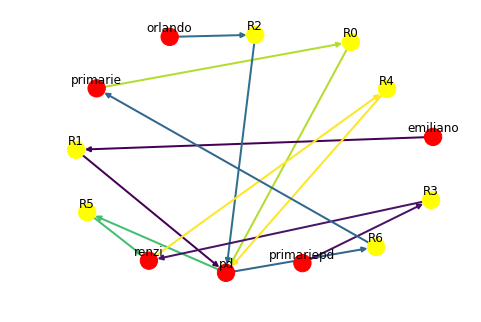

In [313]:
pd = table[(table['antecedents'].apply(lambda x: 'pd' in str(x))) |
             (table['consequents'].apply(lambda x: 'pd' in str(x)))]
#print(pd)
strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6']
draw_graph(pd, 7, strs)  

In [375]:
pd.set_option('display.max_colwidth', -1)
elena=italian_tweets[italian_tweets['content'].apply(lambda x: 'carmenpsicopo' in x)]
elena['content']

Series([], Name: content, dtype: object)

**Conclusions**

> 